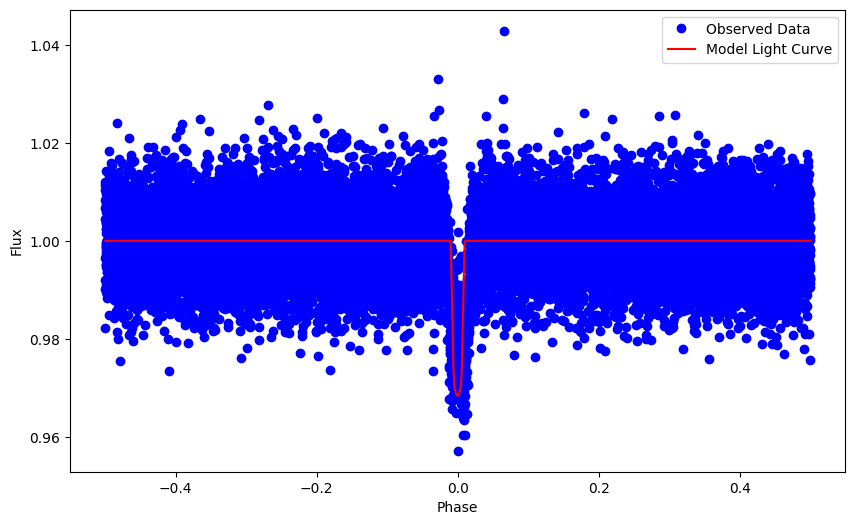

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import math
import batman
from scipy.optimize import minimize
from scipy.signal import find_peaks

#HEY DUMBASS IGNORE THE DATA FROM 2432 TO 2434. IT'S NOT GOOD AT ALL.
#SERIOUSLY SHITHEAD TRY AND SKIP THE DATA, TRY AN XLIM OR SOMETHING
#THIS IS IN ALL CAPITALS AND DELIBERATELY INFLAMMATORY SO YOU READ IT
#REMEMBER: 2432-2434 IS A NO-GO. NOTHING OF VALUE THERE. NOT A HOLY SITE.
#NOT A PLACE OF HONOR. AND SOME OTHER NUCLEAR WASTE WARNINGS THAT APPLY HERE.
#THIS YELLING IS FOR THE CODER, NOT FOR ANYONE ELSE. OTHER PEOPLE READING THIS 
#LIKELY ARE NOT AS DUMB AS THE CODER IS AND DO NOT REQUIRE THIS MUCH TEXT TO 
#GET THEIR ATTENTION.

# Load data (provide the path to your dataset)
data_planet = pd.read_csv("tess2021204101404.csv")
time_data = np.array(data_planet['time'])
flux_data = np.array(data_planet['flux'])

#Defines initial parameters
initial_params = batman.TransitParams()
initial_params.t0 = 2430.15                   # time of inferior conjunction; mid-transit time in days
initial_params.per = 2.770860                   # orbital period in days (estimated)
initial_params.rp = 0.1776                    # planet radius (in units of stellar radii)
initial_params.a = 15                      # semi-major axis (in units of stellar radii)
initial_params.inc = 87.47                    # orbital inclination (in degrees)
initial_params.ecc = 0                     # eccentricity
initial_params.w = 90                      # longitude of periastron (in degrees)
initial_params.limb_dark = "quadratic"     # limb darkening model
initial_params.u = [0.1, 0.3]              # limb darkening coefficients


# Function to detect the first dip in the data
def find_first_dip(flux, prominence=0.01):
    peaks, _ = find_peaks(-flux, prominence=prominence)
    if peaks.any():
        return peaks[0]
    return None

# Define a function to fit transit parameters and generate the model light curve
def fit_transit_parameters(time, flux, initial_params):
    # Detect the first dip
    first_dip_index = find_first_dip(flux)

    if first_dip_index is not None:
        # Use the first dip as the initial transit center time
        tempt0 = time[first_dip_index]

    # Generate a finer time grid during transit for a smoother model
    time_fine = np.linspace(time[0], time[-1], len(time) * 10)

    # Define the transit model parameters
    params = batman.TransitParams()
    params.t0 = initial_params.t0
    params.per = initial_params.per
    params.rp = initial_params.rp
    params.a = initial_params.a
    params.inc = initial_params.inc
    params.ecc = initial_params.ecc
    params.w = initial_params.w
    params.limb_dark = "nonlinear"
    params.u = [0.5, 0.1, 0.1, -0.1]



    # Initialize the BATMAN transit model
    m = batman.TransitModel(params, time_fine)

    # Define a function to minimize, which calculates the residuals
    def objective(p):
        # Update parameters
        params.t0, params.rp, params.per, params.a = p

        # Initialize the BATMAN transit model with updated parameters
        m = batman.TransitModel(params, time)

        # Calculate the model light curve
        flux_model = m.light_curve(params)

        # Calculate residuals
        residuals = flux - flux_model

        # Return the sum of squared residuals
        return np.sum(residuals**2)

    # Perform the optimization to find best-fit parameters (t0, rp, per, a, u1, u2)
    initial_guess = [params.t0, params.rp, params.per, params.a,]
    bounds = [(params.t0 - 5, params.t0 + 5),  # Adjusting bounds for better exploration
              (params.rp * 0.5, params.rp * 2.0),
              (params.per * 0.8, params.per * 1.2),
              (params.a * 0.1, params.a * 10)]

    result = minimize(objective, initial_guess, method='Nelder-Mead', bounds=bounds)

    # Get the best-fit parameters
    best_fit_params = result.x
    params.t0, params.rp, params.per, params.a = best_fit_params

    #print("Final parameters:")
    #print("t0:", params.t0)
    #print("rp:", params.rp)
    #print("per:", params.per)
    #print("a:", params.a)
    #print(result)

    # Initialize the BATMAN transit model with best-fit parameters
    m = batman.TransitModel(params, time)

    # Calculate the model light curve
    flux_model = m.light_curve(params)

    return flux_model, best_fit_params

# Function to generate the model light curve with given parameters
def generate_model(time, params):
    m = batman.TransitModel(params, time)
    return m.light_curve(params)

flux_model, temp_best_fit_params = fit_transit_parameters(time_data, flux_data, initial_params)
# Generate the model light curve with best-fit parameters. 2.07955 is the period divided by 2

best_fit_params = batman.TransitParams()
best_fit_params.t0 = temp_best_fit_params[0]
best_fit_params.per = temp_best_fit_params[2]
best_fit_params.rp = temp_best_fit_params[1]
best_fit_params.a = temp_best_fit_params[3]
best_fit_params.inc = 90
best_fit_params.ecc = 0.0
best_fit_params.w = 90.0
best_fit_params.limb_dark = "nonlinear"
best_fit_params.u = [0.5, 0.1, 0.1, -0.1]

model_time = np.linspace(best_fit_params.t0 - 2.07955, best_fit_params.t0 + 2.07955, len(time_data) * 10)
model_flux = generate_model(model_time, best_fit_params)

# Phase-fold the model
model_phase = ((model_time - best_fit_params.t0 + 0.5 * best_fit_params.per) % best_fit_params.per) - 0.5 * best_fit_params.per

# Phase-fold the data
orbital_phase = ((time_data - best_fit_params.t0 + 0.5 * best_fit_params.per) % best_fit_params.per) - 0.5 * best_fit_params.per


# Phase folding the time data around the period
phase_folded_time = ((time_data - initial_params.t0) / initial_params.per) % 1
phase_folded_time[phase_folded_time > 0.5] -= 1  # Centering around 0


# Sorting the phase and corresponding flux data for plotting
sort_order = np.argsort(phase_folded_time)
sorted_phase = phase_folded_time[sort_order]
sorted_flux = flux_data[sort_order]

# Plot the observed data without connecting the blue points
plt.figure(figsize=(10, 6))
plt.plot(sorted_phase, sorted_flux, 'bo', label='Observed Data')
plt.plot(sorted_phase, flux_model[sort_order], 'r-', label='Model Light Curve')
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.legend()
plt.show()
